#### 패키지 설치 및 라이브러리 로드

In [49]:
!pip install pandas nltk

Defaulting to user installation because normal site-packages is not writeable


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import nltk
import re
import matplotlib.font_manager as fm
import matplotlib as mpl

from matplotlib import font_manager, rc
from scipy.stats import f_oneway
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from itertools import tee
from scipy.stats import chi2_contingency

from wordcloud import WordCloud
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#### 파일 로드

In [52]:
# CSV 파일 읽기
dat = pd.read_csv("./스포츠 및 엔터테인먼트03.csv", encoding='UTF-8') ; dat.head(5)

,상품명,가격,평점,댓글,별점,링크
0,"SCVCN 사이클링 안경 자전거 선글라스, 남성 UV400 안경, 스포츠 MTB 야...","1,391",4.7,NaN,NaN,https://ko.aliexpress.com/item/100500592463696...
1,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...","1,391",4.8,배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하...,5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5...,https://ko.aliexpress.com/item/100500592457862...
2,"야외 캠핑 생존 랜야드 낙하산 로프 하이킹 텐트 액세서리, 7 코어 550 파라코드...","1,125",4.7,감사합니다\n지퍼 손잡이 매듭용으로 좋습니다\n잘받았습니다 잘받았습니다\n이색인줄은...,5\n5\n5\n5\n5\n5\n5\n3\n5\n5\n5\n5\n4\n5\n4\n5...,https://ko.aliexpress.com/item/100500522141320...
3,"접이식 대용량 접이식 왜건, 휴대용 유틸리티 카트, 쇼핑 비치 가든 풀 트롤리, 야...","25,785",4.7,뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 차이나...,5\n5\n5\n5\n5\n5\n4\n4\n5\n5\n5\n5\n5\n5\n5\n4...,https://ko.aliexpress.com/item/100500593200533...
4,"BISINNA 접이식 바베큐 라운드 테이블 스토브, 휴대용 캠핑 바베큐 숯 그릴, ...","16,411",4.8,생각보다 너무괜찮은데요? 후기좋은 이유가있엇네요 불판도생각보다 두껍고튼튼한듯ㅎ 저사...,5\n5\n5\n5\n5\n5\n5\n5\n5\n4\n5\n5\n5\n5\n5\n5...,https://ko.aliexpress.com/item/100500626084886...


In [53]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   상품명     60 non-null     object 
 1   가격      60 non-null     object 
 2   평점      60 non-null     float64
 3   댓글      57 non-null     object 
 4   별점      58 non-null     object 
 5   링크      60 non-null     object 
dtypes: float64(1), object(5)
memory usage: 2.9+ KB


#### 댓글 NaN인경우 제거

In [54]:
# 원래 데이터프레임 길이
original_length = len(dat)

# 댓글이 NaN인 행 제거
dat = dat.dropna(subset=['댓글'])

# 제거된 행의 수
removed_count = original_length - len(dat)

print(f"총 {removed_count}개의 댓글이 NaN인 행이 제거되었습니다.")

총 3개의 댓글이 NaN인 행이 제거되었습니다.


In [55]:
dat.head(5)

,상품명,가격,평점,댓글,별점,링크
1,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...","1,391",4.8,배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하...,5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5...,https://ko.aliexpress.com/item/100500592457862...
2,"야외 캠핑 생존 랜야드 낙하산 로프 하이킹 텐트 액세서리, 7 코어 550 파라코드...","1,125",4.7,감사합니다\n지퍼 손잡이 매듭용으로 좋습니다\n잘받았습니다 잘받았습니다\n이색인줄은...,5\n5\n5\n5\n5\n5\n5\n3\n5\n5\n5\n5\n4\n5\n4\n5...,https://ko.aliexpress.com/item/100500522141320...
3,"접이식 대용량 접이식 왜건, 휴대용 유틸리티 카트, 쇼핑 비치 가든 풀 트롤리, 야...","25,785",4.7,뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 차이나...,5\n5\n5\n5\n5\n5\n4\n4\n5\n5\n5\n5\n5\n5\n5\n4...,https://ko.aliexpress.com/item/100500593200533...
4,"BISINNA 접이식 바베큐 라운드 테이블 스토브, 휴대용 캠핑 바베큐 숯 그릴, ...","16,411",4.8,생각보다 너무괜찮은데요? 후기좋은 이유가있엇네요 불판도생각보다 두껍고튼튼한듯ㅎ 저사...,5\n5\n5\n5\n5\n5\n5\n5\n5\n4\n5\n5\n5\n5\n5\n5...,https://ko.aliexpress.com/item/100500626084886...
5,"튼튼한 라텍스 저항 밴드, 탄성 운동 강도 풀업 보조 밴드, 필라테스 체육관 피트니...","1,391",4.7,잘받았습니다\n좋아요 가격대비 만족합니다\n진짜 빨리받앗어요. 일주일?? 턱걸이하는...,5\n5\n5\n5\n5\n5\n5\n5\n5\n4\n5\n4\n4\n4\n4\n5...,https://ko.aliexpress.com/item/100500545860164...


#### 긍정 / 부정 분류

In [56]:
dat['별점']

1     5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5...
2     5\n5\n5\n5\n5\n5\n5\n3\n5\n5\n5\n5\n4\n5\n4\n5...
3     5\n5\n5\n5\n5\n5\n4\n4\n5\n5\n5\n5\n5\n5\n5\n4...
4     5\n5\n5\n5\n5\n5\n5\n5\n5\n4\n5\n5\n5\n5\n5\n5...
5     5\n5\n5\n5\n5\n5\n5\n5\n5\n4\n5\n4\n4\n4\n4\n5...
6     5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n4\n2\n5\n4\n5\n5...
7     5\n5\n5\n5\n5\n5\n5\n5\n4\n4\n3\n2\n2\n5\n4\n5...
8     5\n5\n4\n5\n5\n4\n5\n5\n5\n4\n5\n5\n5\n5\n4\n4...
9     5\n5\n3\n5\n5\n3\n5\n5\n5\n5\n5\n5\n5\n5\n4\n5...
10    5\n5\n4\n5\n5\n4\n5\n5\n4\n5\n5\n5\n5\n5\n5\n5...
11    5\n5\n4\n5\n5\n4\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5...
12    4\n5\n5\n4\n5\n5\n5\n4\n4\n5\n5\n5\n5\n5\n5\n5...
13    5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5...
14    5\n5\n4\n5\n5\n4\n5\n5\n5\n5\n5\n3\n5\n3\n5\n5...
15    5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5...
17    5\n3\n1\n5\n3\n1\n5\n5\n4\n4\n4\n5\n5\n5\n5\n5...
18    5\n5\n4\n5\n5\n4\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5...
19    5\n5\n5\n5\n5\n5\n5\n5\n3\n5\n4\n5\n5\n5\n

In [57]:
# 별점을 정수형 리스트로 변환
def split_stars(stars):
    return list(map(int, stars.split('\n')))

# 각 행에 대해 별점 리스트로 변환
dat['star_list'] = dat['별점'].apply(split_stars)

# 별점 분포를 계산하기 위한 별점 리스트 플래트닝
all_stars = [star for stars in dat['star_list'] for star in stars]

# 별점별 빈도 계산
star_counts = pd.Series(all_stars).value_counts().sort_index()

# 별점별 빈도 출력
print(star_counts)

# 부정은 1점 (55) + 2점 (27) + 3점 (110) = 192
# 긍정은 4점 (355) + 5점 (1997) = 2352


1      55
2      27
3     110
4     355
5    1997
Name: count, dtype: int64


c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda

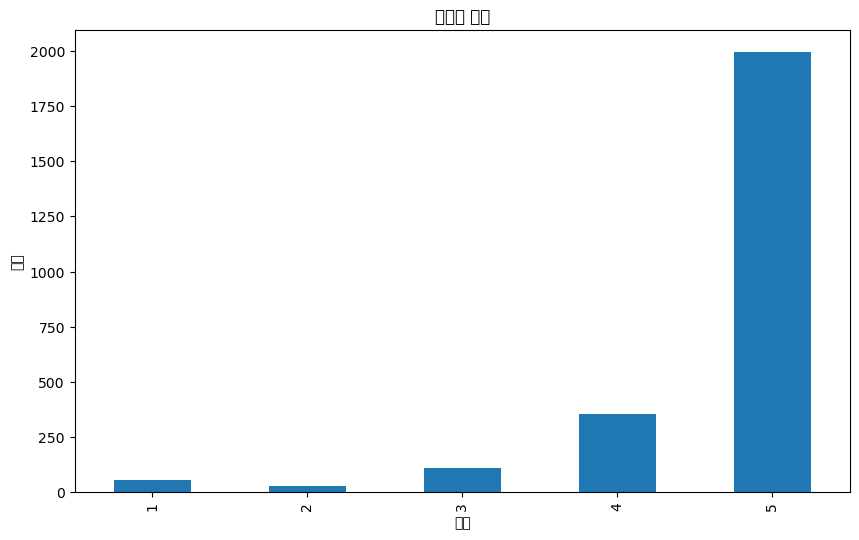

In [58]:
# 별점 분포 시각화
plt.figure(figsize=(10, 6))
star_counts.plot(kind='bar')
plt.xlabel('별점')
plt.ylabel('빈도')
plt.title('별점별 분포')
plt.show()

# 리뷰 시각화의 경우 대부분 긴꼬리분포로 (쏠림현상) 나타남. 정규화하지 않아도 됨.

In [59]:
def classify_sentiment(stars):
    # 별점을 정수형 리스트로 변환
    stars_list = list(map(int, stars.split('\n')))
    
    # 별점이 1, 2, 3 중 하나라도 있으면 부정, 모두 4 또는 5이면 긍정
    if any(star in [1, 2, 3] for star in stars_list):
        return '부정'
    elif all(star in [4, 5] for star in stars_list):
        return '긍정'
    else:
        return '알 수 없음'


In [60]:
# 별점을 정수형 리스트로 변환
def split_stars(stars):
    return list(map(int, stars.split('\n')))

# 각 행에 대해 별점 리스트로 변환
dat['star_list'] = dat['별점'].apply(split_stars)

# 별점 리스트를 긍정/부정 리스트로 변환
def classify_star_list(star_list):
    return ['긍정' if star in [4, 5] else '부정' for star in star_list]

# 별점 리스트에 대한 긍정/부정 리스트 추가
dat['review_list'] = dat['star_list'].apply(classify_star_list)

# 결과 확인
print(dat[['star_list', 'review_list']].head(10))


                                            star_list  \
1   [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
2   [5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 4, 5, 4, ...   
3   [5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, ...   
4   [5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, ...   
5   [5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 4, 4, 4, ...   
6   [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2, 5, 4, 5, ...   
7   [5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 3, 2, 2, 5, 4, ...   
8   [5, 5, 4, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 4, ...   
9   [5, 5, 3, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 4, ...   
10  [5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, ...   

                                          review_list  
1   [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...  
2   [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 부정, 긍정, 긍정, 긍정, 긍...  
3   [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...  
4   [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...  
5   [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...  
6   [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정,

In [61]:
dat['review_list'].str.split(' ')

1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
17   NaN
18   NaN
19   NaN
20   NaN
21   NaN
22   NaN
23   NaN
24   NaN
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
35   NaN
36   NaN
37   NaN
38   NaN
40   NaN
41   NaN
42   NaN
43   NaN
44   NaN
45   NaN
46   NaN
47   NaN
48   NaN
49   NaN
50   NaN
51   NaN
52   NaN
53   NaN
54   NaN
55   NaN
56   NaN
57   NaN
58   NaN
59   NaN
Name: review_list, dtype: float64

In [62]:
dat['긍정 빈도수']

KeyError: '긍정 빈도수'

In [63]:
# 각 상품별 긍정 및 부정 빈도수 계산
dat['긍정 빈도수'] = dat['review_list'].apply(lambda x: x.count('긍정'))
dat['부정 빈도수'] = dat['review_list'].apply(lambda x: x.count('부정'))


# 전체 긍정 및 부정 빈도수 계산
total_positive = dat['긍정 빈도수'].sum()
total_negative = dat['부정 빈도수'].sum()

print(f"전체 긍정 댓글 수: {total_positive}")
print(f"전체 부정 댓글 수: {total_negative}")


전체 긍정 댓글 수: 2352
전체 부정 댓글 수: 192


c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45843 (\N{HANGUL SYLLABLE DAES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44544 (\N{HANGUL SYLLABLE GEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3

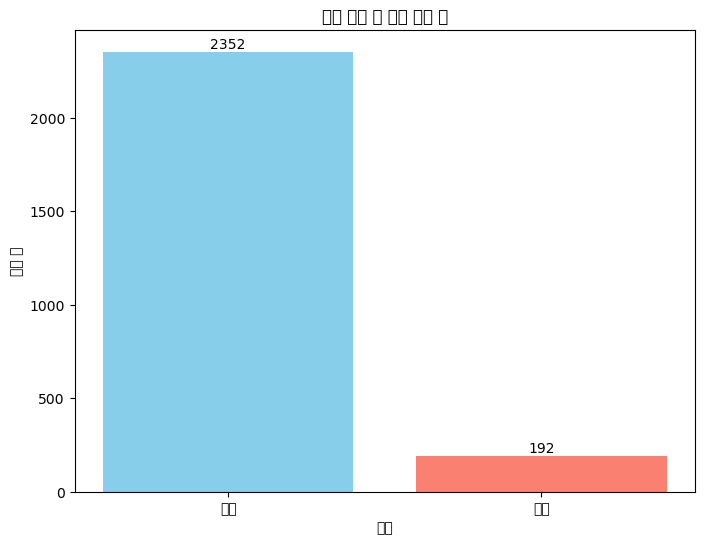

In [64]:
# 히스토그램 그리기
plt.figure(figsize=(8, 6))
bars = plt.bar(['긍정', '부정'], [total_positive, total_negative], color=['skyblue', 'salmon'])
plt.title('전체 긍정 및 부정 댓글 수')
plt.xlabel('감정')
plt.ylabel('댓글 수')

# 빈도수 텍스트 추가
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(int(height)), ha='center', va='bottom')

plt.show()



In [65]:
'''
# 긍정 댓글 수 히스토그램
plt.figure(figsize=(8, 6))
plt.hist(dat['긍정 빈도수'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('긍정 댓글 수 분포')
plt.xlabel('긍정 댓글 수')
plt.ylabel('빈도수')
plt.grid(True)
plt.show()

# 부정 댓글 수 히스토그램
plt.figure(figsize=(8, 6))
plt.hist(dat['부정 빈도수'], bins=20, color='salmon', edgecolor='black', alpha=0.7)
plt.title('부정 댓글 수 분포')
plt.xlabel('부정 댓글 수')
plt.ylabel('빈도수')
plt.grid(True)
plt.show()
'''


"\n# 긍정 댓글 수 히스토그램\nplt.figure(figsize=(8, 6))\nplt.hist(dat['긍정 빈도수'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)\nplt.title('긍정 댓글 수 분포')\nplt.xlabel('긍정 댓글 수')\nplt.ylabel('빈도수')\nplt.grid(True)\nplt.show()\n\n# 부정 댓글 수 히스토그램\nplt.figure(figsize=(8, 6))\nplt.hist(dat['부정 빈도수'], bins=20, color='salmon', edgecolor='black', alpha=0.7)\nplt.title('부정 댓글 수 분포')\nplt.xlabel('부정 댓글 수')\nplt.ylabel('빈도수')\nplt.grid(True)\nplt.show()\n"

In [66]:
dat.head(2)

,상품명,가격,평점,댓글,별점,링크,star_list,review_list,긍정 빈도수,부정 빈도수
1,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...","1,391",4.8,배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하...,5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5...,https://ko.aliexpress.com/item/100500592457862...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...",39,4
2,"야외 캠핑 생존 랜야드 낙하산 로프 하이킹 텐트 액세서리, 7 코어 550 파라코드...","1,125",4.7,감사합니다\n지퍼 손잡이 매듭용으로 좋습니다\n잘받았습니다 잘받았습니다\n이색인줄은...,5\n5\n5\n5\n5\n5\n5\n3\n5\n5\n5\n5\n4\n5\n4\n5...,https://ko.aliexpress.com/item/100500522141320...,"[5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 4, 5, 4, ...","[긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 부정, 긍정, 긍정, 긍정, 긍...",42,1


#### H0 : 가격에 따른 리뷰의 변화는 없을 것이다. H1 : 가격에 따른 리뷰의 변화는 있을 것이다.
#### H0 : 가격에 따른 감정분류 변화는 없을 것이다. H1 : 가격이 따른 감정분류 변화는 있을 것이다. (가격이 낮을수록 부정적인 리뷰가 많을 것이다.)

In [67]:
# 데이터프레임에서 가격과 리뷰 평점 열을 추출
prices = dat['가격']
ratings = dat['평점']

# ANOVA 분석을 통한 가격대 별 리뷰 평점의 차이 검정
f_statistic, p_value = f_oneway(*[ratings[prices == price] for price in prices.unique()])
print("F-statistic:", f_statistic)
print("p-value:", p_value)


F-statistic: 1.7936011760524706
p-value: 0.06760692420921267


In [68]:
dat['긍정 빈도수']

1     39
2     42
3     43
4     43
5     43
6     42
7     40
8     38
9     41
10    40
11    41
12    38
13    43
14    33
15    52
17    39
18    43
19    42
20    41
21    51
22    43
23    43
24    43
25    39
26    38
27    43
28    43
29    43
30    43
31    43
32    43
33    37
34    40
35    43
36    43
37    39
38    42
40    42
41    36
42    29
43    38
44    43
45    41
46    41
47    42
48    40
49    39
50    43
51    38
52    43
53    42
54    42
55    40
56    43
57    43
58    43
59    42
Name: 긍정 빈도수, dtype: int64

In [69]:
dat['부정 빈도수']

1      4
2      1
3      0
4      0
5      0
6      1
7      3
8      5
9      2
10     5
11     6
12     5
13     0
14    10
15     0
17     4
18     1
19     1
20     2
21     7
22     0
23     0
24     0
25     4
26     8
27     1
28     2
29     2
30     4
31     6
32     0
33     6
34     3
35     0
36     0
37     4
38     1
40    13
41     7
42    14
43     5
44    12
45     2
46     9
47     1
48     4
49     4
50     0
51     5
52     1
53     7
54     1
55     3
56     5
57     0
58     0
59     1
Name: 부정 빈도수, dtype: int64

In [70]:
# 데이터프레임에서 긍정 빈도수와 부정 빈도수 열을 추출
positive_counts = dat['긍정 빈도수']
negative_counts = dat['부정 빈도수']

# 카이제곱 검정을 통한 가격대 별 긍정/부정 리뷰 비율의 차이 검정
chi2_stat, p_value, _, _ = chi2_contingency(pd.crosstab(prices, [positive_counts, negative_counts]))
print("Chi-squared statistic:", chi2_stat)
print("p-value:", p_value)


Chi-squared statistic: 380.4150361833289
p-value: 0.5420850419710634


In [71]:
dat['댓글']

1     배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하...
2     감사합니다\n지퍼 손잡이 매듭용으로 좋습니다\n잘받았습니다 잘받았습니다\n이색인줄은...
3     뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 차이나...
4     생각보다 너무괜찮은데요? 후기좋은 이유가있엇네요 불판도생각보다 두껍고튼튼한듯ㅎ 저사...
5     잘받았습니다\n좋아요 가격대비 만족합니다\n진짜 빨리받앗어요. 일주일?? 턱걸이하는...
6     가격은 한국과 비슷한데 퀄리티가 아주좋아요 오랜만에 맘에 드는 상품을 구입한것같아요...
7     크기가 성인 남석 새끼손가락 길이 정도 되네요. 배터리가 얼마나 갈지 모르겠습니다만...
8     아직 사용 전입니다 . 쫀쫀하고 접착력도 좋습니다. 색상도 다양하고 좋습니다. 다용...
9                 매일 열심히하면 좋아질듯함.\n입이 너무아파요\n맛 없어서 버렸어요
10    사이트 설명대로 색깔, 무게, 크기 똑같고 실물보니 맘에 들어요\n가성비 좋아요. ...
11    생각보다 작아용..ㅋㅋ 전투모 56썼던 그나마 작은축이 속합니다만 여성분이나 자녀들...
12    10개 개별포장되어 잘 왔음. 택배가 늦게 와서 좀 그렇지, 물건은 좋음\n붕대보다...
13    박스가 찌그러져서 왔는데 미사용이라 펑크없이 잘 사용되길 기대해 봅니다.\n배송이 ...
14    내구성은 살짝 약해보이긴 한데 가격이 워낙 저렴해서 나쁘진 않은거 같음 추가로 가방...
15            상당히 푸쉬업에 도움이 됩니다\n굿\n가격대비 아주 훌륭합니다 잘쓰겠습니다
17    대만족!! 깐깐하고 세심한 한국인에게도 적극추천할만한제품\n21LB로는 절대 안됩니...
18                    아주 좋아요\n조금 작지만 가성ㅂ 굿\n조금작지만 가성비 굿
19    좋은 제품 잘 사용합니다 가성비 좋아요 굿잡 수고하세요.\n배송은 늦었지만 

In [72]:
dat['review_list']

1     [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...
2     [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 부정, 긍정, 긍정, 긍정, 긍...
3     [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...
4     [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...
5     [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...
6     [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 부...
7     [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 부정, 부...
8     [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...
9     [긍정, 긍정, 부정, 긍정, 긍정, 부정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...
10    [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...
11    [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...
12    [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...
13    [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...
14    [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 부...
15    [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...
17    [긍정, 부정, 부정, 긍정, 부정, 부정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...
18    [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...
19    [긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 부정, 긍정, 긍

In [73]:
# 데이터프레임에서 리뷰 텍스트와 긍정/부정 레이블 열을 추출
reviews = dat['댓글']
sentiments = dat['review_list']

# 텍스트 데이터를 벡터화
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(reviews)

In [74]:
# MultiLabelBinarizer를 사용하여 다중 레이블을 이진 벡터로 변환
mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(sentiments)

# 학습 및 예측
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)
classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# 분류 보고서 출력
print(classification_report(y_test, y_pred, target_names=mlb.classes_))


              precision    recall  f1-score   support

          긍정       1.00      1.00      1.00        12
          부정       0.50      1.00      0.67         6

   micro avg       0.75      1.00      0.86        18
   macro avg       0.75      1.00      0.83        18
weighted avg       0.83      1.00      0.89        18
 samples avg       0.75      1.00      0.83        18



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label 0 is present in all training examples.
  warnings.warn(


In [75]:
def extract_price(price_str):
    try:
        # 정규 표현식을 사용하여 숫자 부분만 추출
        price = re.findall(r'\d+', price_str.replace(',', ''))[0]
        return int(price)
    except IndexError:
        # 숫자를 찾지 못하면 NaN 반환
        return float('nan')

# 가격 데이터 정제
dat['가격'] = dat['가격'].apply(extract_price)
dat['가격']

1      1391
2      1125
3     25785
4     16411
5      1391
6      1391
7      1391
8      1391
9      1222
10     1391
11     1391
12     1391
13     1391
14     2282
15     1391
17     1391
18     1391
19     1391
20     1391
21     1391
22     1391
23     1391
24     1391
25     1391
26     1391
27     1391
28    12903
29    34918
30     1391
31    31030
32     1391
33     1391
34     1391
35     6604
36     1391
37     1391
38    38157
40     6913
41     1391
42     1391
43     1391
44     1391
45     1391
46     1391
47     1391
48     6829
49     1391
50     1391
51     1391
52     1518
53     1391
54     1391
55     8776
56     1391
57     1813
58     1391
59     1391
Name: 가격, dtype: int64

In [76]:
# 첫 번째 상품명 가져오기
product_1 = dat['상품명'][1]


# 첫 번째 상품명에 대한 데이터 필터링
dat1 = dat[dat['상품명'] == product_1]

# 첫 번째 상품명에 대한 첫 번째 댓글 가져오기
comments_1 = dat['댓글'].iloc[0]

# 결과 출력
print(f"상품명: {product_1}")
print(f"첫 번째 댓글: {comments_1}")


상품명: 역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스핏 핸드 그립, 손목 지지대
첫 번째 댓글: 배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하고 스트랩 로고처리로 고급져보이네요 스트랩에 미끄럽지 않게 미끄렁방지 처리까지 되어있네요 저렴하게 구매할수 있어 정말 만족합니다 강력 추천하고 싶네요 ㅋ
배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천~~ㅋ
정말 좋습니다. 기대이상인듯. 2~3만원대 WSF나 Schiek의 리프팅 스트랩에 비교해도 기능성으로는 전혀 문제가 없을듯합니다. 착용감은 좋은데 사용전이라 장시간 사용했을때 실리콘이 안떨어지길 바래봅니다. 아 바느질은 좀 거친감이 있습니다.
3개중에 한개는 포장이 열린 상태로 왔습니다 하지만 상품에는 아무 문제 없고 미끄럼방지 처리도 깔끔하게 잘 되어있어서 가성비 너무 좋게 잘 샀습니다~
아 배송은 8일 걸려서 배송지연으로 배송무료 쿠폰 받았습니다.
아주 고퀄은 아니지만 스트랩이란건 튼튼하면 그만이니 이 가격은 아주아주 혜자. 깔별로 사모으는것도 재밋을듯요
한번에 다왔습니다. 배송이 조금 늦어져서 쿠폰도 받고 했지만.. 그래도 안전하게 배송 잘왔습니다. 주문하실때 여러번 나눠서 주문하면 통관하는데 오래 걸리는듯 합니다. 잘왔습니다~ 잘쓰겠습니다.
저렴해서 기대 안했는데 미끄럼 방지도 돼있네요. 좋아요
배송은 조금 느리지만 상품은 좋습니다.
좋습니다 좋겠습니다 좋으네 좋아요
좋아용
매우 만족합니다. 좋아요~~^^
배송도빠르고 저렴하고좋습니다 ㅎㅎ
좋습니다
가격 저렴하고 쓸만합니다
가격대비 품질 좋은 편. 내구성은 오래 안 써봐서 아직 모름. 마프 스트랩 썼었는데 마프꺼보다 쿠션은 훨씬 말랑하고 스트랩은 얇은 편. 완전 면 재질은 아님. 그래도 가격대비 이 정도면 만족. 사용성만 좋으면 여기로 정착할 듯. 개인적으로 미끄럼방지 고무가 바벨 쪽이 아니라 손에 있었으면 좋았을 듯. 원래 손 쪽에 있는 거라던데..
대만

In [77]:
# dat 데이터프레임에서 필요한 열 선택
df_1 = dat.loc[1, ['상품명', '댓글', '가격', '별점', 'review_list']].copy()

# 시리즈를 데이터프레임으로 변환
df_1 = pd.DataFrame([df_1])

# 데이터프레임 출력
df_1


,상품명,댓글,가격,별점,review_list
1,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하...,1391,5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5\n5...,"[긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍..."


In [78]:
# 별점과 댓글을 리스트로 변환
dat['별점'] = dat['별점'].str.split('\n')
dat['댓글'] = dat['댓글'].str.split('\n')


In [79]:
dat.head()

,상품명,가격,평점,댓글,별점,링크,star_list,review_list,긍정 빈도수,부정 빈도수
1,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",1391,4.8,[배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",https://ko.aliexpress.com/item/100500592457862...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...",39,4
2,"야외 캠핑 생존 랜야드 낙하산 로프 하이킹 텐트 액세서리, 7 코어 550 파라코드...",1125,4.7,"[감사합니다, 지퍼 손잡이 매듭용으로 좋습니다, 잘받았습니다 잘받았습니다, 이색인줄...","[5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 4, 5, 4, ...",https://ko.aliexpress.com/item/100500522141320...,"[5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 4, 5, 4, ...","[긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 부정, 긍정, 긍정, 긍정, 긍...",42,1
3,"접이식 대용량 접이식 왜건, 휴대용 유틸리티 카트, 쇼핑 비치 가든 풀 트롤리, 야...",25785,4.7,[뭔 배송하면서 바닷물에 담궈서 가져오냐? 쓰기도 전에 녹슬어서 오는 메이드인 차이...,"[5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, ...",https://ko.aliexpress.com/item/100500593200533...,"[5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, ...","[긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...",43,0
4,"BISINNA 접이식 바베큐 라운드 테이블 스토브, 휴대용 캠핑 바베큐 숯 그릴, ...",16411,4.8,[생각보다 너무괜찮은데요? 후기좋은 이유가있엇네요 불판도생각보다 두껍고튼튼한듯ㅎ 저...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, ...",https://ko.aliexpress.com/item/100500626084886...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, ...","[긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...",43,0
5,"튼튼한 라텍스 저항 밴드, 탄성 운동 강도 풀업 보조 밴드, 필라테스 체육관 피트니...",1391,4.7,"[잘받았습니다, 좋아요 가격대비 만족합니다, 진짜 빨리받앗어요. 일주일?? 턱걸이하...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 4, 4, 4, ...",https://ko.aliexpress.com/item/100500545860164...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 4, 4, 4, ...","[긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍정, 긍...",43,0


In [80]:
# 확장된 데이터프레임 생성
expanded_rows = []
for idx, row in dat.iterrows():
    stars = row['별점']
    comments = row['댓글']
    reviews = row['review_list']
    for star, comment, review in zip(stars, comments, reviews):
        expanded_rows.append({
            '상품명': row['상품명'],
            '댓글': comment,
            '가격': row['가격'],
            '별점': star,
            'review_list': review
        })

df_expanded = pd.DataFrame(expanded_rows)
df_expanded

,상품명,댓글,가격,별점,review_list
0,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하...,1391,5,긍정
1,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천~~ㅋ,1391,5,긍정
2,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",정말 좋습니다. 기대이상인듯. 2~3만원대 WSF나 Schiek의 리프팅 스트랩에 ...,1391,5,긍정
3,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",3개중에 한개는 포장이 열린 상태로 왔습니다 하지만 상품에는 아무 문제 없고 미끄럼...,1391,5,긍정
4,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",아 배송은 8일 걸려서 배송지연으로 배송무료 쿠폰 받았습니다.,1391,5,긍정
...,...,...,...,...,...
1364,"피트니스 발목 스트랩 조정 가능한 D 링 지지 커프, 체육관 다리 근력 운동 풀리,...",좋아요. 추천합니다.,1391,5,긍정
1365,"피트니스 발목 스트랩 조정 가능한 D 링 지지 커프, 체육관 다리 근력 운동 풀리,...",발 찯 잡아줍니당!!,1391,5,긍정
1366,"피트니스 발목 스트랩 조정 가능한 D 링 지지 커프, 체육관 다리 근력 운동 풀리,...",잘 산거 같아여,1391,5,긍정
1367,"피트니스 발목 스트랩 조정 가능한 D 링 지지 커프, 체육관 다리 근력 운동 풀리,...",가격 대비 가성비 좋고 이가격에 이각격이면 꽤 쓸만합니다 .,1391,5,긍정


#### 키워드 추출

In [81]:
import re

# 키워드 '배송'이 포함된 댓글을 추출
keyword = '배송'

# '배송' 키워드가 포함된 댓글을 저장할 리스트 초기화
comments_with_keyword = [comment for comment in df_expanded['댓글'] if re.findall(keyword, comment)]

# 결과를 데이터프레임으로 변환
df_with_keyword = df_expanded[df_expanded['댓글'].apply(lambda x: bool(re.findall(keyword, x)))]

# 결과 출력
print(f"키워드 '{keyword}'가 포함된 댓글:")
df_with_keyword


키워드 '배송'가 포함된 댓글:


,상품명,댓글,가격,별점,review_list
0,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하...,1391,5,긍정
1,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천~~ㅋ,1391,5,긍정
4,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",아 배송은 8일 걸려서 배송지연으로 배송무료 쿠폰 받았습니다.,1391,5,긍정
6,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",한번에 다왔습니다. 배송이 조금 늦어져서 쿠폰도 받고 했지만.. 그래도 안전하게 배...,1391,5,긍정
8,"역도 스트랩 실리콘 리프팅 손목 스트랩, 미끄럼 방지, 힘 훈련, 데드리프트 크로스...",배송은 조금 느리지만 상품은 좋습니다.,1391,5,긍정
...,...,...,...,...,...
1322,일렉트릭 기타 픽 어쿠스틱 음악 픽 플렉트럼 0.58/0.71/0.81/0.96/1...,잘 배송되었습니다. 잘 사용하겠습니다.,1391,5,긍정
1326,일렉트릭 기타 픽 어쿠스틱 음악 픽 플렉트럼 0.58/0.71/0.81/0.96/1...,제품 케이스에 잘 담겨져 배송되었으며 제품도 만족한,1391,5,긍정
1333,일렉트릭 기타 픽 어쿠스틱 음악 픽 플렉트럼 0.58/0.71/0.81/0.96/1...,빠른배송에 좋은제품 사용잘하겠습니다,1391,5,긍정
1357,"FTK 탄화플루오르 코팅 낚싯줄, 탄소 섬유 모노필라멘트 리더 라인, 잉어 낚시 침...",배송이 빠릅니다👍,1391,4,긍정


#### 명사추출 함수

In [82]:
'''
def extract_nouns(dataframe):
    """
    주어진 데이터프레임에서 각 상품명의 댓글에서 명사를 추출하여 출력합니다.
    
    Parameters:
    dataframe (pd.DataFrame): 상품명과 댓글을 포함한 데이터프레임
    """
    # Okt 객체 생성
    okt = Okt()
    
    # 데이터프레임의 각 행에 대해 반복
    for index, row in dataframe.iterrows():
        # 상품명과 해당 인덱스의 댓글을 가져오기
        product_name = row['상품명']
        comment = row['댓글']
            
        # 명사 추출
        nouns = okt.nouns(comment)
        
        # 결과 출력
        print(f"상품명: {product_name}")
        print(f"명사 추출: {nouns}\n")
        print('=' * 100)


# 함수 호출
print("\n상품명과 명사 추출 결과 출력:")
extract_nouns(df_expanded)
'''


'\ndef extract_nouns(dataframe):\n    """\n    주어진 데이터프레임에서 각 상품명의 댓글에서 명사를 추출하여 출력합니다.\n    \n    Parameters:\n    dataframe (pd.DataFrame): 상품명과 댓글을 포함한 데이터프레임\n    """\n    # Okt 객체 생성\n    okt = Okt()\n    \n    # 데이터프레임의 각 행에 대해 반복\n    for index, row in dataframe.iterrows():\n        # 상품명과 해당 인덱스의 댓글을 가져오기\n        product_name = row[\'상품명\']\n        comment = row[\'댓글\']\n            \n        # 명사 추출\n        nouns = okt.nouns(comment)\n        \n        # 결과 출력\n        print(f"상품명: {product_name}")\n        print(f"명사 추출: {nouns}\n")\n        print(\'=\' * 100)\n\n\n# 함수 호출\nprint("\n상품명과 명사 추출 결과 출력:")\nextract_nouns(df_expanded)\n'

In [83]:
def extract_nouns(dataframe):
    """
    주어진 데이터프레임에서 각 상품명의 댓글에서 명사를 추출하여 출력합니다.
    
    Parameters:
    dataframe (pd.DataFrame): 상품명과 댓글을 포함한 데이터프레임
    """
    # Okt 객체 생성
    okt = Okt()
    
    # 데이터프레임의 각 행에 대해 반복
    for product_name, group_df in dataframe.groupby('상품명'):
        # 해당 상품명의 모든 댓글을 하나의 문자열로 합침
        comments_combined = ' '.join(group_df['댓글'].dropna())
        
        # 명사 추출
        nouns = okt.nouns(comments_combined)
        
        # 결과 출력
        print(f"상품명: {product_name}")
        print(f"명사 추출: {nouns}\n")
        print('=' * 100)


# 함수 호출
print("\n상품명과 명사 추출 결과 출력:")
extract_nouns(df_expanded)



상품명과 명사 추출 결과 출력:
상품명: 2021 일본 금속 주조 지그 스푼 10/15/20/30/40/50g 해안 캐스팅 지깅 물고기 농어 낚시 미끼 인공 미끼 태클
명사 추출: ['사이트', '설명', '색깔', '무게', '크기', '실물', '맘', '가성', '비', '잡고', '중', '가장', '마음', '드네', '메탈', '상태', '바늘', '사이트', '설명', '색깔', '무게', '크기', '실물', '맘', '사이트', '설명', '색깔', '무게', '크기', '실물', '맘', '금액', '결재', '상품', '그냥', '도착', '갠츈', '무게', '배송', '삼치', '타작', '기원', '물건', '사진', '제품', '제품', '이건', '배송', '물건', '추천', '추천', '사용', '전이', '사용', '후', '다시', '글', '배송', '만듬새', '만족', '가성', '비', '물고기', '제품', '퀄리티', '듯', '환불', '함', '사용', '전', '함', '가격', '품질', '호기심', '주문', '함', '가성', '비', '가격', '잘못', '보고', '구매', '함', '한국', '가게', '비교', '가격', '만족도', '굿', '가격', '다음', '날', '먹음', '가격', '대비', '그냥', '사용', '전이', '더', '이상', '별', '무리', '미사', '용', '중립', '평가', '배송', '매우']

상품명: 8-22mm 범용 Torx 렌치 자체 조임 조정 가능한 안경 렌치 보드, 더블 헤드 Torx 스패너 공장용 수공구
명사 추출: ['사용', '전', '비상', '용', '스페너', '대용', '아주', '심플', '습']

상품명: Aorace 미노우 낚시 루어, 3D 눈 크랭크베이트 워블러, 인공 플라스틱 하드 베이트, 낚시 태클, 70mm, 8g
명사 추출: ['마감', '가성', '비', '인쇼', '용', '사용', '예정', '마감', '가성'

상품명: BISINNA 접이식 바베큐 라운드 테이블 스토브, 휴대용 캠핑 바베큐 숯 그릴, 보관 가방 포함, 파티오 차 끓이기
명사 추출: ['생각', '요', '후기', '이유', '엇네', '불', '판도', '생각', '사고', '가격', '이또', '가성', '비', '사실', '모든', '부위', '소재', '품질', '편이', '디자인', '구성', '가격', '비', '높이', '그릴', '여분', '수십', '사', '게시', '조립', '가성', '비', '듯', '캠핑', '고기', '먹기', '이즈', '이번', '주말', '사용', '예정', '정말', '기재', '가격', '가성', '비', '이번', '주', '캠핑', '쓸껀데', '기대', '품질', '코', '제품', '사진', '구매', '깨', '사용', '전', '가성', '비', '최고', '가격', '실용', '적임', '가방', '더', '완전', '마음', '강', '구성', '가성', '비', '짱', '실용', '가격', '정말', '마음', '주문', '도착', '가방', '기타', '부속품', '모두', '누락', '도착', '상판', '자국', '가격', '생각', '수긍', '참고', '석쇠', '지름', '실', '참고', '석쇠', '크기', '쿠팡', '주문', '리', '마감', '다른', '후기', '석쇠', '일회용', '석쇠', '사서', '나', '리가', '듯', '코인', '할인', '가격', '구입', '무게', '감', '미니', '숯불', '구이', '재료', '오', '배송', '회사', '코인', '추가', '할인', '세명', '똥방뎅', '의자', '사용', '재질', '정말', '괘않다', '전용', '가방', '트렁크', '친구', '언제', '고기', '생각', '좀', '커서', '이즈', '허리', '높이', '태', '가격', '구성', '가성', '비', '후회', '구매', '단점', '라면', '고기', '불',

In [84]:
from konlpy.tag import Okt
import pandas as pd

def extract_nouns_by_sentiment(dataframe):
    """
    주어진 데이터프레임에서 각 상품명의 댓글을 긍정과 부정으로 나누어 명사를 추출하여 출력합니다.
    
    Parameters:
    dataframe (pd.DataFrame): 상품명, 댓글, 리뷰 상태를 포함한 데이터프레임
    """
    # Okt 객체 생성
    okt = Okt()
    

    # 긍정 댓글과 부정 댓글을 저장할 딕셔너리 초기화
    positive_comments = {}
    negative_comments = {}
    
    # 데이터프레임의 각 행에 대해 반복
    for product_name, group_df in dataframe.groupby('상품명'):
        # 해당 상품명의 긍정과 부정 댓글을 나눔
        positive_reviews = group_df[group_df['review_list'] == '긍정']['댓글'].dropna()
        negative_reviews = group_df[group_df['review_list'] == '부정']['댓글'].dropna()
        
        # 긍정 댓글을 하나의 문자열로 합침
        if not positive_reviews.empty:
            positive_comments_combined = ' '.join(positive_reviews)
            # 긍정 댓글에서 명사 추출
            positive_nouns = okt.nouns(positive_comments_combined)
            positive_comments[product_name] = positive_nouns
        
        # 부정 댓글을 하나의 문자열로 합침
        if not negative_reviews.empty:
            negative_comments_combined = ' '.join(negative_reviews)
            # 부정 댓글에서 명사 추출
            negative_nouns = okt.nouns(negative_comments_combined)
            negative_comments[product_name] = negative_nouns
    
    # 결과 출력
    for product_name in positive_comments:
        print(f"상품명 (긍정): {product_name}")
        print(f"명사 추출: {positive_comments[product_name]}\n")
        print('=' * 100)
    
    for product_name in negative_comments:
        print(f"상품명 (부정): {product_name}")
        print(f"명사 추출: {negative_comments[product_name]}\n")
        print('=' * 100)

# 함수 호출
print("\n상품명과 명사 추출 결과 출력:")
extract_nouns_by_sentiment(df_expanded)



상품명과 명사 추출 결과 출력:
상품명 (긍정): 2021 일본 금속 주조 지그 스푼 10/15/20/30/40/50g 해안 캐스팅 지깅 물고기 농어 낚시 미끼 인공 미끼 태클
명사 추출: ['사이트', '설명', '색깔', '무게', '크기', '실물', '맘', '가성', '비', '잡고', '중', '가장', '마음', '드네', '메탈', '상태', '바늘', '사이트', '설명', '색깔', '무게', '크기', '실물', '맘', '사이트', '설명', '색깔', '무게', '크기', '실물', '맘', '금액', '결재', '상품', '그냥', '도착', '갠츈', '무게', '배송', '삼치', '타작', '기원', '물건', '사진', '제품', '제품', '이건', '배송', '물건', '추천', '사용', '전이', '사용', '후', '다시', '글', '배송', '만듬새', '만족', '가성', '비', '물고기', '제품', '퀄리티', '듯', '환불', '함', '사용', '전', '함', '가격', '품질', '호기심', '주문', '함', '가성', '비', '가격', '잘못', '보고', '구매', '함', '한국', '가게', '비교', '가격', '만족도', '굿', '가격', '가격', '대비', '그냥', '사용', '전이', '더', '이상', '별', '무리']

상품명 (긍정): 8-22mm 범용 Torx 렌치 자체 조임 조정 가능한 안경 렌치 보드, 더블 헤드 Torx 스패너 공장용 수공구
명사 추출: ['사용', '전', '비상', '용', '스페너', '대용', '아주', '심플', '습']

상품명 (긍정): Aorace 미노우 낚시 루어, 3D 눈 크랭크베이트 워블러, 인공 플라스틱 하드 베이트, 낚시 태클, 70mm, 8g
명사 추출: ['마감', '가성', '비', '인쇼', '용', '사용', '예정', '마감', '가성', '비', '인쇼', '용', '사용', '예정', '마감', '가성', '

In [85]:
def extract_nouns_by_sentiment(dataframe):
    """
    주어진 데이터프레임에서 각 상품명의 댓글을 긍정과 부정으로 나누어 명사를 추출하고 빈도수까지 계산하여 저장합니다.
    
    Parameters:
    dataframe (pd.DataFrame): 상품명, 댓글, 리뷰 상태를 포함한 데이터프레임
    """
    # Okt 객체 생성
    okt = Okt()
    
    # 명사와 빈도를 저장할 리스트 초기화
    combined_nouns = []
    
    # 데이터프레임의 각 행에 대해 반복
    for product_name, group_df in dataframe.groupby('상품명'):
        # 해당 상품명의 긍정과 부정 댓글을 나눔
        positive_reviews = group_df[group_df['review_list'] == '긍정']['댓글'].dropna()
        negative_reviews = group_df[group_df['review_list'] == '부정']['댓글'].dropna()
        
        # 긍정 댓글을 하나의 문자열로 합침
        if not positive_reviews.empty:
            positive_comments_combined = ' '.join(positive_reviews)
            # 긍정 댓글에서 명사 추출
            positive_nouns = okt.nouns(positive_comments_combined)
            # 명사 빈도 계산
            positive_wordcount = Counter(positive_nouns)
            combined_nouns.extend([(product_name, noun, freq, '긍정') for noun, freq in positive_wordcount.items()])
        
        # 부정 댓글을 하나의 문자열로 합침
        if not negative_reviews.empty:
            negative_comments_combined = ' '.join(negative_reviews)
            # 부정 댓글에서 명사 추출
            negative_nouns = okt.nouns(negative_comments_combined)
            # 명사 빈도 계산
            negative_wordcount = Counter(negative_nouns)
            combined_nouns.extend([(product_name, noun, freq, '부정') for noun, freq in negative_wordcount.items()])
    
    # 명사 리스트를 데이터프레임으로 변환
    nouns_df = pd.DataFrame(combined_nouns, columns=['상품명', '명사', '빈도', 'review_list']) #'상품명'
    return nouns_df

# 함수 호출
nouns_df = extract_nouns_by_sentiment(df_expanded)

print("\n명사 추출 및 빈도수 결과 데이터프레임:")
nouns_df


명사 추출 및 빈도수 결과 데이터프레임:


,상품명,명사,빈도,review_list
0,2021 일본 금속 주조 지그 스푼 10/15/20/30/40/50g 해안 캐스팅 ...,사이트,3,긍정
1,2021 일본 금속 주조 지그 스푼 10/15/20/30/40/50g 해안 캐스팅 ...,설명,3,긍정
2,2021 일본 금속 주조 지그 스푼 10/15/20/30/40/50g 해안 캐스팅 ...,색깔,3,긍정
3,2021 일본 금속 주조 지그 스푼 10/15/20/30/40/50g 해안 캐스팅 ...,무게,4,긍정
4,2021 일본 금속 주조 지그 스푼 10/15/20/30/40/50g 해안 캐스팅 ...,크기,3,긍정
...,...,...,...,...
3867,"필라테스용 튼튼한 라텍스 저항 밴드, 탄성 운동 강도 풀업 보조 밴드, 체육관 피트...",냄새,1,부정
3868,"필라테스용 튼튼한 라텍스 저항 밴드, 탄성 운동 강도 풀업 보조 밴드, 체육관 피트...",안남,1,부정
3869,"필라테스용 튼튼한 라텍스 저항 밴드, 탄성 운동 강도 풀업 보조 밴드, 체육관 피트...",감사,1,부정
3870,"필라테스용 튼튼한 라텍스 저항 밴드, 탄성 운동 강도 풀업 보조 밴드, 체육관 피트...",생각,1,부정


In [86]:
def extract_nouns_by_sentiment(dataframe):
    """
    주어진 데이터프레임에서 댓글을 긍정과 부정으로 나누어 명사를 추출하고 빈도수까지 계산하여 저장합니다.
    
    Parameters:
    dataframe (pd.DataFrame): 댓글, 리뷰 상태를 포함한 데이터프레임
    """
    # Okt 객체 생성
    okt = Okt()
    
    # 긍정 댓글과 부정 댓글을 나눔
    positive_reviews = dataframe[dataframe['review_list'] == '긍정']['댓글'].dropna()
    negative_reviews = dataframe[dataframe['review_list'] == '부정']['댓글'].dropna()
    
    # 명사와 빈도를 저장할 리스트 초기화
    combined_nouns = []
    
    # 긍정 댓글을 하나의 문자열로 합침
    if not positive_reviews.empty:
        positive_comments_combined = ' '.join(positive_reviews)
        # 긍정 댓글에서 명사 추출
        positive_nouns = okt.nouns(positive_comments_combined)
        # 명사 빈도 계산
        positive_wordcount = Counter(positive_nouns)
        combined_nouns.extend([(noun, freq, '긍정') for noun, freq in positive_wordcount.items()])
    
    # 부정 댓글을 하나의 문자열로 합침
    if not negative_reviews.empty:
        negative_comments_combined = ' '.join(negative_reviews)
        # 부정 댓글에서 명사 추출
        negative_nouns = okt.nouns(negative_comments_combined)
        # 명사 빈도 계산
        negative_wordcount = Counter(negative_nouns)
        combined_nouns.extend([(noun, freq, '부정') for noun, freq in negative_wordcount.items()])
    
    # 명사 리스트를 데이터프레임으로 변환
    nouns_df = pd.DataFrame(combined_nouns, columns=['명사', '빈도', 'review_list'])
    
    # 명사 데이터프레임을 CSV 파일로 저장
    nouns_df.to_csv('nouns_with_freq.csv', index=False, encoding='utf-8-sig')
    
    return nouns_df

# 함수 호출
nouns_df = extract_nouns_by_sentiment(df_expanded)

print("\n스포츠용품_명사 추출 및 빈도수 결과 데이터프레임:")
nouns_df



스포츠용품_명사 추출 및 빈도수 결과 데이터프레임:


,명사,빈도,review_list
0,배송,187,긍정
1,생각,80,긍정
2,도착,47,긍정
3,손목,3,긍정
4,스트랩,7,긍정
...,...,...,...
1702,반,2,부정
1703,여기,2,부정
1704,안,2,부정
1705,손,1,부정


In [87]:
nouns_df[nouns_df['review_list'] == '긍정']

,명사,빈도,review_list
0,배송,187,긍정
1,생각,80,긍정
2,도착,47,긍정
3,손목,3,긍정
4,스트랩,7,긍정
...,...,...,...
1502,발,1,긍정
1503,찯,1,긍정
1504,격,1,긍정
1505,부직포,1,긍정


In [88]:
nouns_df[nouns_df['review_list'] == '부정']

,명사,빈도,review_list
1507,배송,17,부정
1508,아주,5,부정
1509,알레르기,1,부정
1510,가렵,1,부정
1511,짤갛,1,부정
...,...,...,...
1702,반,2,부정
1703,여기,2,부정
1704,안,2,부정
1705,손,1,부정


In [89]:
# CSV 파일 읽기
noun_df_freq = pd.read_csv("./nouns_with_freq.csv", encoding='UTF-8') ; noun_df_freq.head(5)

,명사,빈도,review_list
0,배송,187,긍정
1,생각,80,긍정
2,도착,47,긍정
3,손목,3,긍정
4,스트랩,7,긍정


In [90]:
'''
# TF-IDF 변환기 생성
tfidf_vectorizer = TfidfVectorizer()

# 텍스트 데이터를 TF-IDF 행렬로 변환
tfidf_matrix = tfidf_vectorizer.fit_transform(noun_df_freq['명사'])

# TF-IDF 값을 데이터프레임으로 변환
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# TF-IDF 값 데이터프레임 출력
print(tfidf_df)
'''


"\n# TF-IDF 변환기 생성\ntfidf_vectorizer = TfidfVectorizer()\n\n# 텍스트 데이터를 TF-IDF 행렬로 변환\ntfidf_matrix = tfidf_vectorizer.fit_transform(noun_df_freq['명사'])\n\n# TF-IDF 값을 데이터프레임으로 변환\ntfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())\n\n# TF-IDF 값 데이터프레임 출력\nprint(tfidf_df)\n"

C:\Users\user\AppData\Local\Temp\ipykernel_37952\3162978613.py:12: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_37952\3162978613.py:12: UserWarning: Glyph 44172 (\N{HANGUL SYLLABLE GE}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_37952\3162978613.py:12: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_37952\3162978613.py:12: UserWarning: Glyph 44620 (\N{HANGUL SYLLABLE GGA}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_37952\3162978613.py:12: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_37952\3162978613.py:12: UserWarning: Glyph 45140 (\N{HANGUL SYLLABLE GGEUM}) missing from current font.
  plt.tight_layout()
C:\U

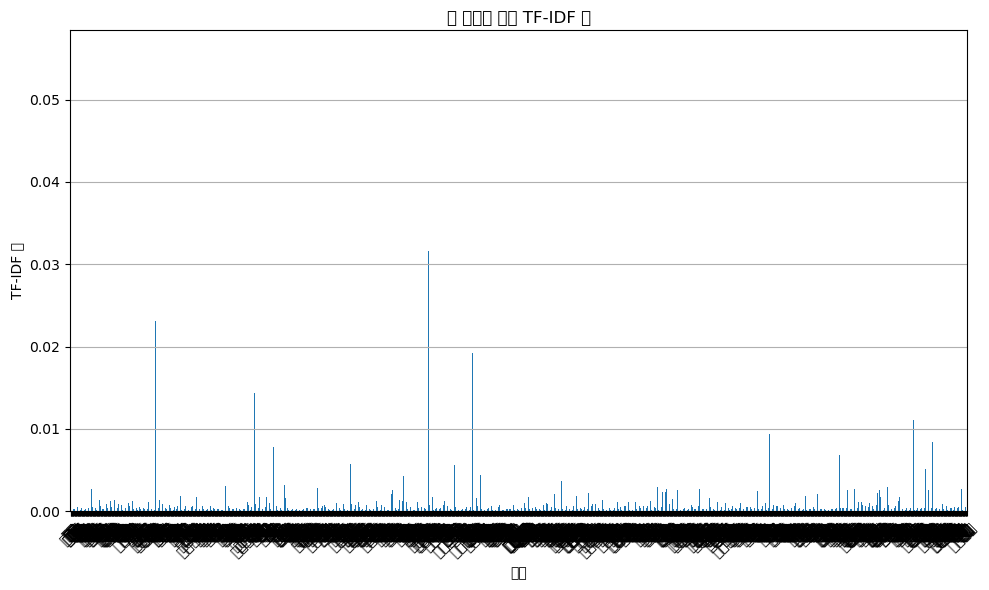

In [100]:
# TF-IDF 값들의 평균 계산
tfidf_mean = tfidf_df.mean()

# TF-IDF 값들을 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
tfidf_mean.plot(kind='bar')
plt.title('각 명사의 평균 TF-IDF 값')
plt.xlabel('명사')
plt.ylabel('TF-IDF 값')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### 연결중심성 시각화

In [92]:
df_expanded['댓글']

0       배송은 생각보다 빨리도착했네요 손목 스트랩 1쌍~레드 디자인 이쁘고 마감처리 깔끔하...
1          배송 빠르고 색상 디자인 마감처리 깔끔하니 가성비 좋아요 만족합니다 강력 추천~~ㅋ
2       정말 좋습니다. 기대이상인듯. 2~3만원대 WSF나 Schiek의 리프팅 스트랩에 ...
3       3개중에 한개는 포장이 열린 상태로 왔습니다 하지만 상품에는 아무 문제 없고 미끄럼...
4                      아 배송은 8일 걸려서 배송지연으로 배송무료 쿠폰 받았습니다.
                              ...                        
1364                                          좋아요. 추천합니다.
1365                                          발 찯 잡아줍니당!!
1366                                             잘 산거 같아여
1367                    가격 대비 가성비 좋고 이가격에 이각격이면 꽤 쓸만합니다 .
1368                            부직포 붙이는 부분이 고리랑 뒤엉켜서 애매함.
Name: 댓글, Length: 1369, dtype: object

In [93]:
noun_df_freq['명사']

0        배송
1        생각
2        도착
3        손목
4       스트랩
       ... 
1702      반
1703     여기
1704      안
1705      손
1706      짐
Name: 명사, Length: 1707, dtype: object

In [94]:
# TF-IDF 계산 함수
def calculate_tfidf(dataframe):
    okt = Okt()
    vectorizer = CountVectorizer(tokenizer=okt.nouns, min_df=1)
    dtm = vectorizer.fit_transform(dataframe['댓글'].dropna())
    words = vectorizer.get_feature_names_out()
    
    tfidf_transformer = TfidfTransformer()
    tfidf = tfidf_transformer.fit_transform(dtm)
    
    tfidf_df = pd.DataFrame(tfidf.toarray(), columns=words)
    tfidf_filtered_df = tfidf_df.loc[:, (tfidf_df > 0).any(axis=0)]
    return tfidf_filtered_df

# TF-IDF 계산
tfidf_df = calculate_tfidf(df_expanded)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [95]:
# 연결 중심성 계산 함수
def calculate_centrality(dataframe):
    okt = Okt()
    G = nx.Graph()
    
    for review in dataframe['댓글'].dropna():
        nouns = okt.nouns(review)
        for i in range(len(nouns)):
            for j in range(i + 1, len(nouns)):
                if G.has_edge(nouns[i], nouns[j]):
                    G[nouns[i]][nouns[j]]['weight'] += 1
                else:
                    G.add_edge(nouns[i], nouns[j], weight=1)
    
    centrality = nx.degree_centrality(G)
    centrality_df = pd.DataFrame(centrality.items(), columns=['명사', '연결 중심성'])
    return centrality_df

# 연결 중심성 계산
centrality_df = calculate_centrality(df_expanded)

In [96]:
# 가능한 font list 확인
f = [f.name for f in fm.fontManager.ttflist]
print(f)

# 확인 이후
#plt.rc('font', family='Malgun Gothic')

['DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Sans', 'DejaVu Serif', 'STIXSizeOneSym', 'DejaVu Sans', 'STIXSizeFiveSym', 'cmb10', 'STIXSizeFourSym', 'DejaVu Serif', 'STIXGeneral', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'STIXSizeTwoSym', 'STIXNonUnicode', 'DejaVu Serif', 'STIXGeneral', 'STIXNonUnicode', 'STIXSizeOneSym', 'cmmi10', 'DejaVu Sans', 'DejaVu Sans', 'cmss10', 'cmr10', 'STIXGeneral', 'cmsy10', 'STIXSizeThreeSym', 'STIXSizeThreeSym', 'STIXNonUnicode', 'STIXGeneral', 'DejaVu Serif Display', 'cmtt10', 'STIXSizeTwoSym', 'STIXSizeFourSym', 'STIXNonUnicode', 'DejaVu Sans Mono', 'DejaVu Serif', 'cmex10', 'NanumGothicOTF', 'Tahoma', 'Footlight MT Light', 'HYPMokGak-Bold', 'High Tower Text', 'Century Schoolbook', 'MingLiU-ExtB', 'Garamond', 'Perpetua', 'Harrington', 'Wide Latin', 'Franklin Gothic Book', 'Candara', 'SimSun', 'Constantia', 'Mistral', 'Bookman Old Style', 'Lucida Bright', 'Harlow Solid Italic', 'NanumGothic', 'Candara', 'MS Reference Specialty', 'Consolas', 'Vladim

In [97]:
'''
font_path = 'C:/Windows/Fonts/NanumGothicBold.ttf' # 사용하려는 폰트 파일 경로
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)
'''
# 마이너스 기호 문제 해결하기
mpl.rcParams['axes.unicode_minus'] = False

# 연결 중심성 계산
centrality_df = calculate_centrality(df_expanded)

# 명사별 평균 TF-IDF 계산
nouns_tfidf = tfidf_df.mean(axis=0).reset_index()
nouns_tfidf.columns = ['명사', 'TF-IDF']

# 명사 빈도와 연결 중심성 병합
nouns_df_merged = nouns_df.groupby('명사')['빈도'].sum().reset_index()
nouns_df_merged = nouns_df_merged.merge(nouns_tfidf, on='명사', how='left')
nouns_df_merged = nouns_df_merged.merge(centrality_df, on='명사', how='left')

# 결과 출력
print("\n명사별 빈도, TF-IDF, 연결 중심성 결과 데이터프레임:")
print(nouns_df_merged.head(10))

# 네트워크 그래프 시각화
G = nx.Graph()
for _, row in nouns_df_merged.iterrows():
    G.add_node(row['명사'], size=row['빈도'] * 100)

for review in df_expanded['댓글'].dropna():
    nouns = okt.nouns(review)
    for i in range(len(nouns)):
        for j in range(i + 1, len(nouns)):
            if G.has_edge(nouns[i], nouns[j]):
                G[nouns[i]][nouns[j]]['weight'] += 1
            else:
                G.add_edge(nouns[i], nouns[j], weight=1)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=[G.nodes[n]['size'] for n in G.nodes], node_color='skyblue', font_size=10, alpha=0.7)
plt.title('명사 간 연결 중심성을 나타낸 네트워크 그래프')
plt.rc('font', family='Malgun Gothic')
plt.show()



명사별 빈도, TF-IDF, 연결 중심성 결과 데이터프레임:
    명사   빈도    TF-IDF    연결 중심성
0   가게    2  0.000532  0.011104
1   가격  164  0.032465  0.345526
2  가까이    1  0.000345  0.003266
3   가끔    2  0.000443  0.019595
4   가능    2  0.000289  0.045069
5   가도    2  0.000311  0.031352
6  가랑이    1  0.000283  0.003919
7  가려움    1  0.000250  0.006532
8   가렵    1  0.000422  0.001306
9   가루    1  0.000170  0.009798


NameError: name 'okt' is not defined

In [ ]:
'''
# TF-IDF 변환기 생성
tfidf_vectorizer = TfidfVectorizer()

# 텍스트 데이터를 TF-IDF 행렬로 변환
tfidf_matrix = tfidf_vectorizer.fit_transform(noun_df_freq['명사'])

# TF-IDF 값을 데이터프레임으로 변환
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# TF-IDF 값 데이터프레임 출력
print(tfidf_df)
'''

In [ ]:
'''
# CountVectorizer를 사용하여 DTM 생성
vectorizer = CountVectorizer(tokenizer=okt.nouns, min_df=1)
dtm = vectorizer.fit_transform(noun_df_freq['명사'])
words = vectorizer.get_feature_names_out()
'''

"\n# CountVectorizer를 사용하여 DTM 생성\nvectorizer = CountVectorizer(tokenizer=okt.nouns, min_df=1)\ndtm = vectorizer.fit_transform(noun_df_freq['명사'])\nwords = vectorizer.get_feature_names_out()\n"

In [ ]:
'''
# 단어-문서 행렬을 배열로 변환
word_cooc = (dtm.T * dtm).toarray()  # 동시 출현 행렬
np.fill_diagonal(word_cooc, 0)  # 대각선 값은 0으로 설정
'''

In [ ]:
'''
def generate_bigrams(text):
    # 주어진 텍스트를 단어 토큰으로 나눕니다.
    words = word_tokenize(text)
    
    # 이웃하는 단어 쌍(bigram)을 생성합니다.
    # words[i]는 현재 단어를, words[i + 1]은 다음 단어를 나타냅니다.
    bigrams = [(words[i], words[i + 1]) for i in range(len(words) - 1)]
    
    # 생성된 bigram 목록을 반환합니다.
    return bigrams

dat['bigrams'] = dat['text'].apply(generate_bigrams)

In [ ]:
'''
# bigram을 데이터프레임으로 변환합니다.
bigram_df = pd.DataFrame([(book, bigram[0], bigram[1]) for book, bigrams in zip(data['book'], data['bigrams']) for bigram in bigrams], columns=['book', 'word1', 'word2'])
bigram_df
'''

In [ ]:
'''
# bigram 빈도 계산
bigram_counts = filtered_bigrams.groupby(['word1', 'word2']).size().reset_index(name='count')
bigram_counts = bigram_counts[bigram_counts['count'] > 50]
bigram_counts 
'''

In [ ]:
'''
# 네트워크 그래프 생성
G = nx.from_pandas_edgelist(bigram_counts, 'word1', 'word2', ['count'])
'''

In [ ]:
'''
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, with_labels=True, node_size=20, font_size=10, edge_color='gray')
plt.title('Bigram Network Graph')
plt.show()
'''

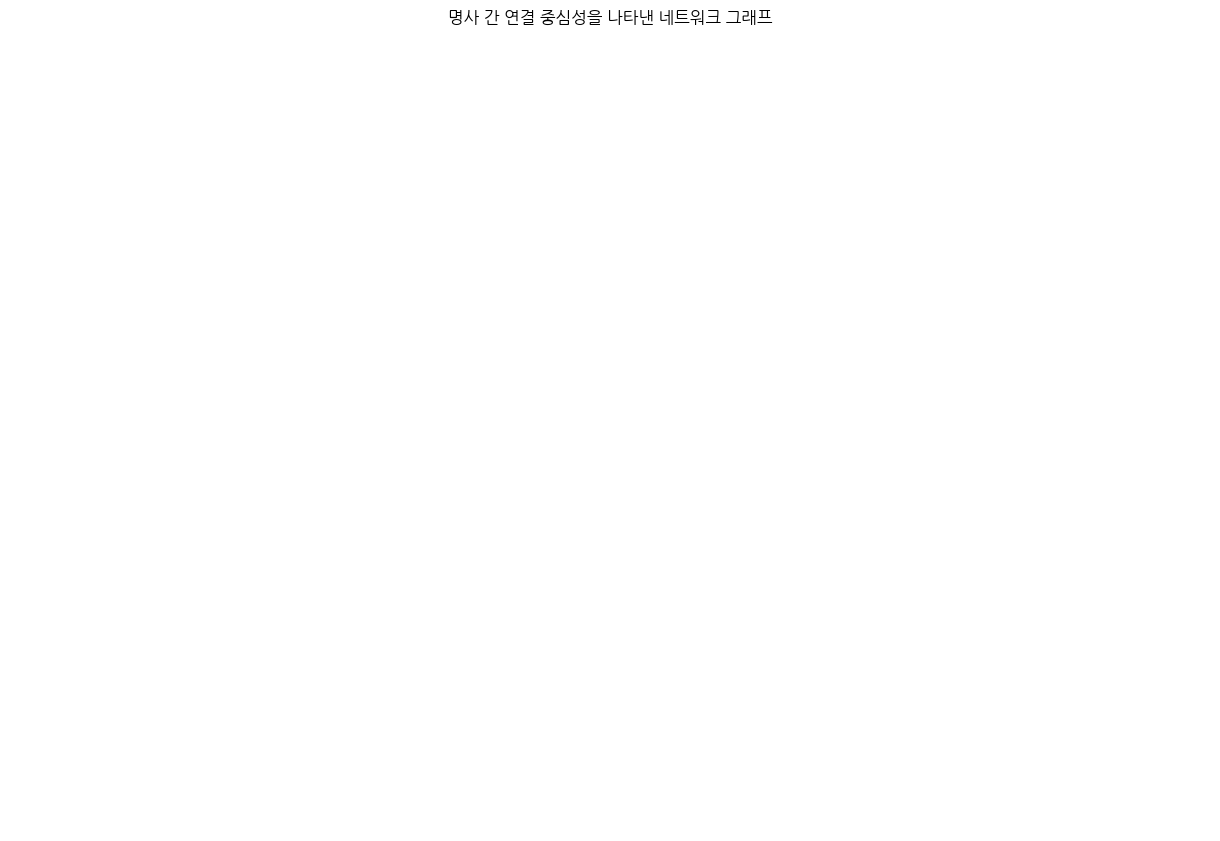

In [ ]:
# 그래프 생성
G = nx.Graph()

# 각 명사 간의 연결 정보 추가
for _, row in nouns_df.iterrows():  # 데이터프레임 변수를 적절하게 수정
    nouns = row['명사'].split()
    for i in range(len(nouns)):
        for j in range(i+1, len(nouns)):
            G.add_edge(nouns[i], nouns[j])

# 연결 중심성 계산
centrality = nx.degree_centrality(G)

# 결과를 데이터프레임으로 변환
centrality_df = pd.DataFrame(centrality.items(), columns=['명사', '연결 중심성'])

# 연결 중심성 값을 시각화할 노드 크기 계산
node_sizes = [centrality[node] * 10000 for node in G.nodes()]

# 네트워크 그래프 그리기
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_size=node_sizes, node_color='skyblue', font_size=10, alpha=0.7)
plt.title('명사 간 연결 중심성을 나타낸 네트워크 그래프')
plt.show()



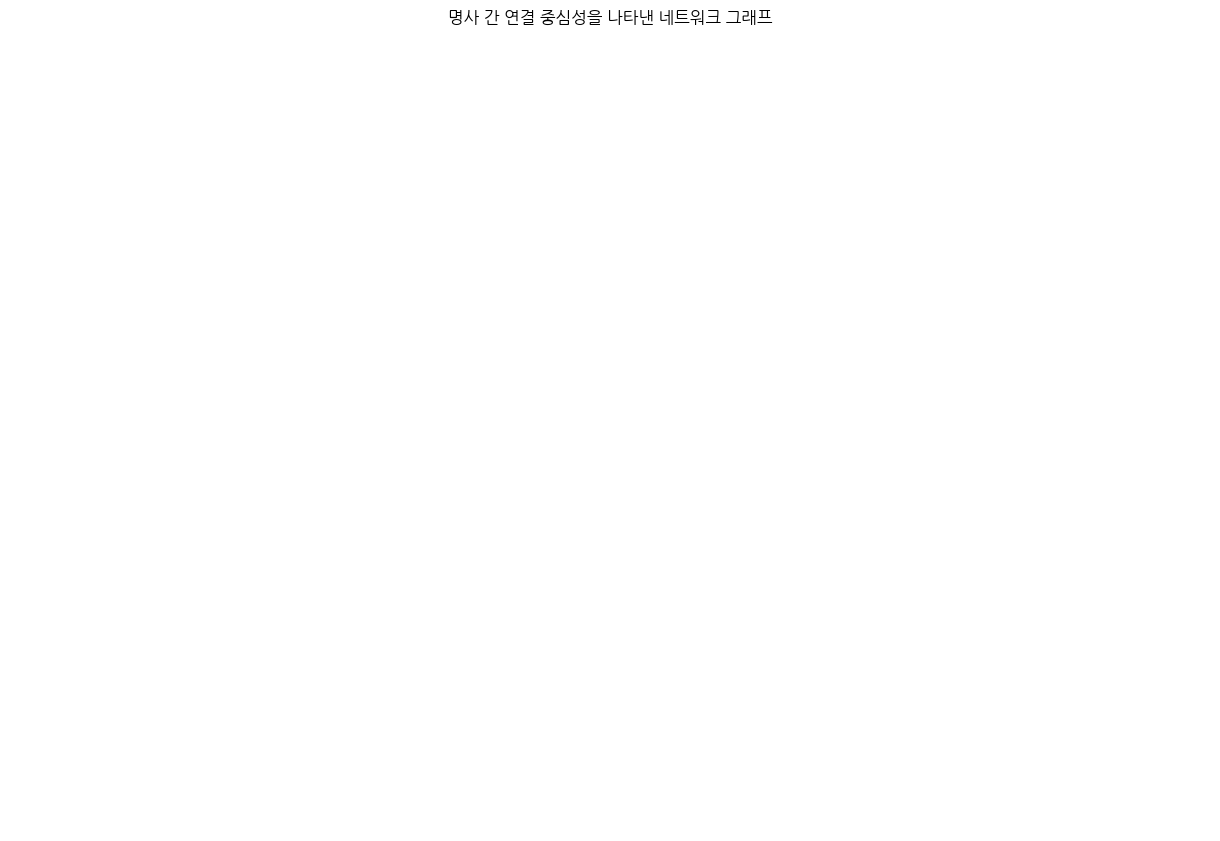

In [ ]:
# 연결 중심성 값을 시각화할 노드 크기 계산
node_sizes = [centrality[node] * 10000 for node in G.nodes()]

# 네트워크 그래프 그리기
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_size=node_sizes, node_color='skyblue', font_size=10, alpha=0.7)
plt.title('명사 간 연결 중심성을 나타낸 네트워크 그래프')
plt.show()

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U5'), dtype('float64')) -> None

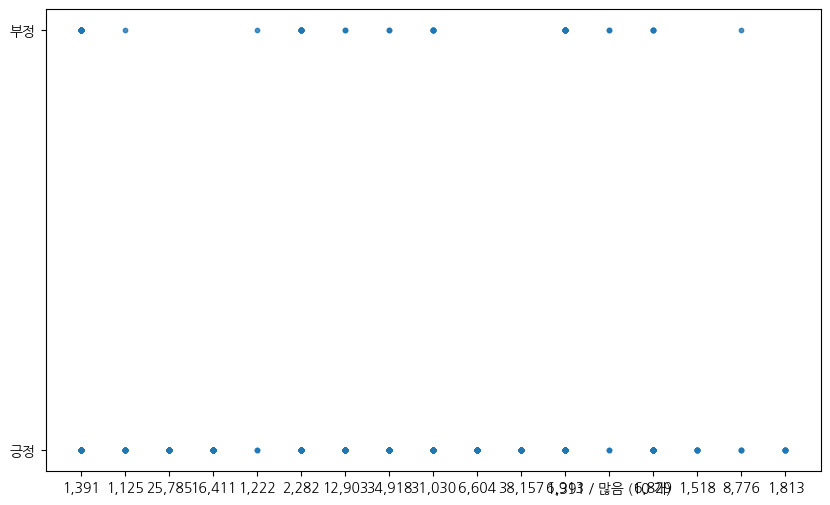

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='가격', y='review_list', data=df_expanded, scatter_kws={'s':10}, line_kws={"color":"r"})
plt.title('가격과 review_list의 관계 산점도와 회귀선')
plt.xlabel('가격')
plt.ylabel('review_list')
plt.show()